# install flappy bird gym

In [1]:
! pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /tmp/pip-req-build-jba7w2aw
  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /tmp/pip-req-build-jba7w2aw
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit ca2797e9270195313423324c9d0f205f6cbb3d28
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 20.4 MB/s eta 0:00:00
  Created wheel for text-flappy-bird-gym: filename=text_flappy_bird_gym-0.1.1-py3-none-any.whl size=7771 sha256=4edcbb57b9b3c959c7c03e48826084731fffef061e3d4985dee3fcf538b5f742
  Stored in directory: /tmp/pip-ephem-wheel-cache-g20k9soy/wheels/a1/07/d2/74e9570f22696f6a81089c4e5dbe11248ff1e4b3236dafe59d
Successfully built text-flappy-bird-gym
  Attempting uninstall: gymnasium
    Found existing installation: gym

In [2]:
# test the environment
import os, sys
import gymnasium as gym
import time
import text_flappy_bird_gym

# if __name__ == '__main__':

    # initiate environment
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
#'TextFlappyBird-screen-v0' or 'TextFlappyBird-v0', only difference would be returned observation
#I choose env2, which would return  the distance of the player from the center of the closest upcoming pipe gap (TextFlappyBird-v0) along the two axes (x,y)
obs = env.reset()

# iterate
while True:

    # Select next action
    action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)
    print('observation is:', obs)

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS

    # If player is dead break
    if done:
        break

env.close()


observation is: (12, -2)
Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[      @             ]
[                    ]
[                    ]
[                    ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=12,dy=-2)
observation is: (11, -3)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[      @          |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=11,dy=-3)
observ

# Implementaion of  Sarsa(λ) agent

In [4]:
import json
import random
import numpy as np
from collections import defaultdict
import os, sys
import gymnasium as gym
import time
import text_flappy_bird_gym
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()

class SARSAAgent:
    ''' SARSA Agent with Monte Carlo-style output format. '''

    def __init__(self, actions, probFlap=0.5):
        """
        Initialize the SARSA Agent.

        Args:
            actions (list): List of possible actions.
            probFlap (float): Probability of flapping when choosing a random action.
        """
        self.actions = actions
        self.probFlap = probFlap
        self.qValues = defaultdict(lambda: [0, 0])  # Q-table with default [0, 0] for each state


    def act(self, state):
        """Epsilon-greedy action selection."""
        if random.random() < self.epsilon:
            return random.choice(self.actions)  # Random action
        return np.argmax(self.qValues[state])  # Choose action with highest Q-value

    def train(self, numIters=20000, epsilon=0.1, discount=1, eta=0.9,
              epsilonDecay=False, etaDecay=False):
        """
        Train the SARSA agent and return (Q, policy, episode_rewards).

        Args:
            numIters (int): Number of training episodes.
            epsilon (float): Initial exploration rate.
            discount (float): Discount factor.
            eta (float): Learning rate.
            epsilonDecay (bool): Whether to decay epsilon over time.
            etaDecay (bool): Whether to decay eta over time.

        Returns:
            tuple: (Q-table, optimal policy, episode rewards)
        """
        self.epsilon = epsilon
        self.discount = discount
        self.eta = eta
        self.epsilonDecay = epsilonDecay
        self.etaDecay = etaDecay

        episode_rewards = []  # Store total rewards per episode
        maxScore = 0

        for i in tqdm(range(numIters)):
            # if i % 50 == 0 or i == numIters - 1:
            #     print(f"Iteration: {i}")

            # Epsilon decay
            self.epsilon = self.epsilon / (i + 1) if self.epsilonDecay else epsilon

            totalReward = 0
            state,info = env.reset()
            action = self.act(state)

            while True:
                nextState, reward, done, _,info = env.step(action)
                nextAction = self.act(nextState)

                # SARSA Update Rule:
                # Q(s,a) = Q(s,a) + α * (r + γ * Q(s', a') - Q(s,a))
                self.qValues[state][action] += self.eta * (
                    reward + self.discount * self.qValues[nextState][nextAction] - self.qValues[state][action]
                )
                state, action = nextState, nextAction
                totalReward += reward

                if done:
                    break

            episode_rewards.append(totalReward)  # Store episode reward
            maxScore = max(maxScore, totalReward)

            if self.etaDecay:
                self.eta *= (i + 1) / (i + 2)
            if self.epsilonDecay:
                self.epsilon = max(0.01, epsilon * 0.99)

        env.close()
        print("Max Score Train:", maxScore)

        return self.qValues, self.get_optimal_policy(), episode_rewards

    def get_optimal_policy(self):
        """Extract the optimal policy from Q-values."""
        return {state: np.argmax(actions) for state, actions in self.qValues.items()}

    def saveQValues(self, filename='qValues.json'):
        """Save Q-values to a JSON file."""
        with open(filename, 'w') as fp:
            json.dump(self.qValues, fp)

    def loadQValues(self, filename='qValues.json'):
        """Load Q-values from a JSON file."""
        with open(filename) as fp:
            self.qValues = json.load(fp)


In [ ]:
# numIters=20000
# epsilon=0.1
# discount=1
# eta=0.1
agent = SARSAAgent(actions=[0, 1])
Q, policy, episode_rewards = agent.train(numIters=250000,epsilon=0.1,discount=0.99,eta=0.1,epsilonDecay=False,etaDecay=False)

100%|██████████| 250000/250000 [07:17<00:00, 570.95it/s]

Max Score Train: 1639


In [ ]:
import os
import sys
import time
import gymnasium as gym
import text_flappy_bird_gym

# Initialize environment
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

# Function to choose action based on learned policy
def select_action(state):
    return policy.get(state, env.action_space.sample())  # Default to a random action if state is unseen

# Reset environment before running learned policy
state, info = env.reset()
done = False

# Game loop using the learned policy
while not done:
    action = select_action(state)  # Get action from policy
    print('state is', state)
    state, reward, done, _, info = env.step(action)

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2)  # Adjust speed for FPS control

env.close()

## successfully run for 30 minutes without mistake and got score of 1051

流式输出内容被截断，只能显示最后 5000 行内容。
[       |         |  ]
[       |         |  ]
[       |         |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=1,dy=0)
state is (1, 0)
Text Flappy Bird!
Score: 1028
----------------------
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[                |   ]
[      @         |   ]
[                    ]
[                    ]
[      |             ]
[      |             ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=0,dy=-1)
state is (0, -1)
Text Flappy Bird!
Score: 1029
----------------------
[     |         |    ]
[     |         |    ]
[     |         |    ]
[     |         |    ]
[     |         |    ]
[      @        |    ]
[               |    ]
[                    ]
[                    ]
[     |              ]
[     |              ]
[     |         

KeyboardInterrupt: 

## Save best model using pickle

In [ ]:
# save training result Q and Policy
import pickle
import os
from collections import defaultdict

def default_value():
    return [0, 0]

data_Q = defaultdict(default_value)  # Use the regular function here
for k, v in Q.items():
    data_Q[k] = v

NameError: name 'Q' is not defined

In [ ]:
# save training result Q and Policy
import pickle
import os
best_model_mont_carlo = {
        "Q": data_Q,
        "policy": policy,
        "episode_rewards": episode_rewards
    }
filename = "/content/drive/MyDrive/Reinforcement Learning/individual assignment/best_model_sarsa.pkl"
with open(filename, "wb") as f:
    pickle.dump(best_model_mont_carlo, f)

In [ ]:
## stock the best model Q
with open("sarsa_Q_final.txt", "w") as f:
    f.write(str(Q))
with open("sarsa_results_final.txt", "w") as f:
    f.write(str(episode_rewards))

## get model with best results

In [5]:
import pickle
def default_value():
    return [0, 0]

filename = "/content/drive/MyDrive/Reinforcement Learning/individual assignment/best_model_sarsa.pkl"
if __name__ == "__main__":
  with open(filename, "rb") as f:
      best_model_sarsa = pickle.load(f)

  # Extract Q, policy, and episode_rewards
#load my stocked best model from files
agent_best_sarsa= SARSAAgent(actions=[0, 1])
agent_best_sarsa.Q = best_model_sarsa["Q"]
agent_best_sarsa.policy = best_model_sarsa["policy"]
agent_best_sarsa.episode_rewards = best_model_sarsa["episode_rewards"]


In [ ]:
# try model performance
import os
import sys
import time
import gymnasium as gym
import text_flappy_bird_gym

policy_best_sarsa= agent_best_sarsa.policy

# Initialize environment
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

# Function to choose action based on learned policy
def select_action(state):
    return policy_best_sarsa.get(state, env.action_space.sample())  # Default to a random action if state is unseen

# Reset environment before running learned policy
state, info = env.reset()
done = False

# Game loop using the learned policy
while not done:
    action = select_action(state)  # Get action from policy
    print('state is', state)
    state, reward, done, _, info = env.step(action)

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2)  # Adjust speed for FPS control

env.close()

流式输出内容被截断，只能显示最后 5000 行内容。
[                  | ]
[        |         | ]
[        |         | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=2,dy=-1)
state is (2, -1)
Text Flappy Bird!
Score: 24
----------------------
[       |         |  ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
[       |         |  ]
[       |            ]
[                    ]
[                    ]
[                    ]
[                 |  ]
[      @|         |  ]
[       |         |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=1,dy=2)
state is (1, 2)
Text Flappy Bird!
Score: 24
----------------------
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |         |   ]
[      |             ]
[                    ]
[                    ]
[                   

KeyboardInterrupt: 

## State-Value Function Plot

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_state_value_function(agent):
    """Plots the state-value function V(s) derived from Q-values."""

    # Extract unique states from Q-table
    states = list(agent.Q.keys())

    # Compute V(s) as max Q(s, a)
    V = {state: max(agent.Q[state]) for state in states}

    # Convert states into a 2D grid (if applicable)
    x_coords = [s[0] for s in states]  # Assuming state is tuple (x, y, ...)
    y_coords = [s[1] for s in states]
    values = [V[s] for s in states]

    # Create a scatter plot or heatmap
    plt.figure(figsize=(8, 6))
    plt.scatter(x_coords, y_coords, c=values, cmap='viridis', marker='s', s=100)
    plt.colorbar(label="State Value V(s)")
    plt.xlabel("State Dimension 0")
    plt.ylabel("State Dimension 1")
    plt.title("Sarsa(λ) State-Value Function")
    plt.show()

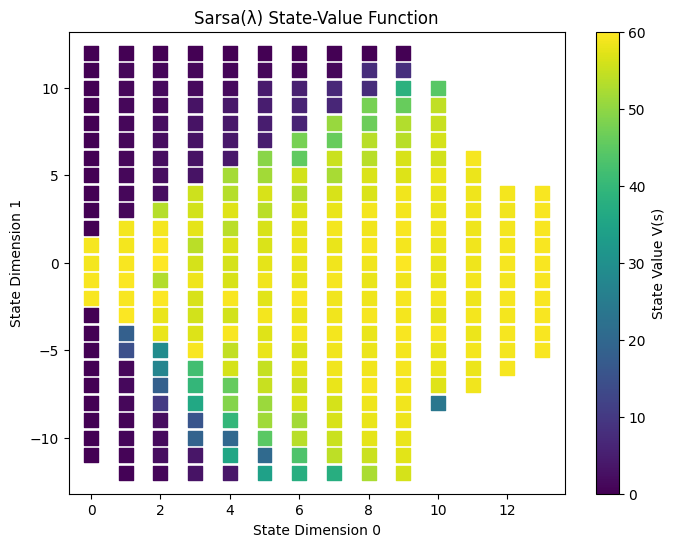

In [ ]:
plot_state_value_function(agent_best_sarsa)

## Performance Graph (Reward per Episode)

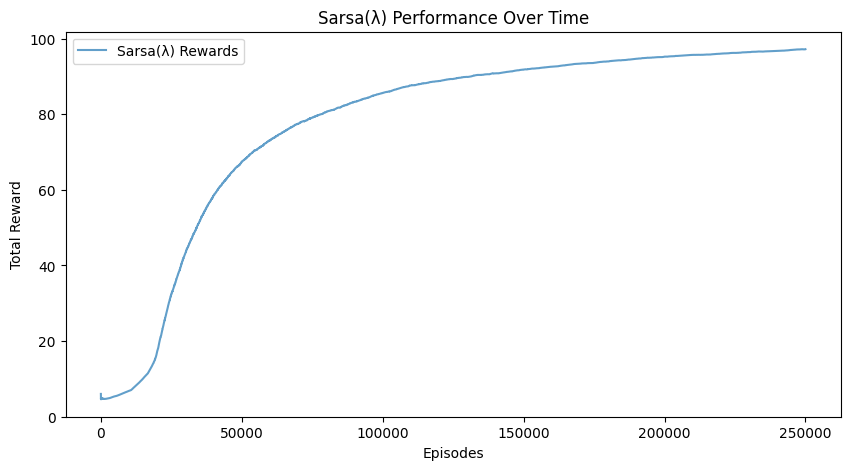

In [ ]:
# Assuming 'episode_rewards' stores total rewards per episode
plt.figure(figsize=(10, 5))
#plot the average of reward
plt.plot(np.arange(len(episode_rewards)), np.array(episode_rewards).cumsum()/ np.arange(1, len(episode_rewards) + 1), label="Sarsa(λ) Rewards", alpha=0.7)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Sarsa(λ) Performance Over Time")
plt.legend()
plt.show()


## parameter-sweep analysis

100%|██████████| 2500/2500 [00:00<00:00, 12658.87it/s]


Max Score Train: 7


100%|██████████| 2500/2500 [00:00<00:00, 13052.93it/s]


Max Score Train: 8


100%|██████████| 2500/2500 [00:00<00:00, 9573.54it/s]


Max Score Train: 13


100%|██████████| 2500/2500 [00:00<00:00, 13090.15it/s]


Max Score Train: 23


100%|██████████| 2500/2500 [00:00<00:00, 8326.85it/s]


Max Score Train: 41


100%|██████████| 2500/2500 [00:00<00:00, 16570.26it/s]


Max Score Train: 8


100%|██████████| 2500/2500 [00:00<00:00, 14017.85it/s]


Max Score Train: 10


100%|██████████| 2500/2500 [00:00<00:00, 11467.22it/s]


Max Score Train: 13


100%|██████████| 2500/2500 [00:00<00:00, 14570.66it/s]


Max Score Train: 15


100%|██████████| 2500/2500 [00:00<00:00, 5844.53it/s]


Max Score Train: 35


100%|██████████| 2500/2500 [00:00<00:00, 14503.47it/s]


Max Score Train: 6


100%|██████████| 2500/2500 [00:00<00:00, 12147.50it/s]


Max Score Train: 8


100%|██████████| 2500/2500 [00:00<00:00, 11424.80it/s]


Max Score Train: 13


100%|██████████| 2500/2500 [00:00<00:00, 7603.59it/s]


Max Score Train: 29


100%|██████████| 2500/2500 [00:00<00:00, 3948.86it/s]


Max Score Train: 97


100%|██████████| 2500/2500 [00:00<00:00, 11325.02it/s]


Max Score Train: 8


100%|██████████| 2500/2500 [00:00<00:00, 8231.22it/s]


Max Score Train: 12


100%|██████████| 2500/2500 [00:00<00:00, 2938.41it/s]


Max Score Train: 17


100%|██████████| 2500/2500 [00:01<00:00, 1853.66it/s]


Max Score Train: 57


100%|██████████| 2500/2500 [00:01<00:00, 2124.34it/s]


Max Score Train: 123


100%|██████████| 2500/2500 [00:00<00:00, 12035.42it/s]


Max Score Train: 8


100%|██████████| 2500/2500 [00:00<00:00, 8671.44it/s]


Max Score Train: 72


100%|██████████| 2500/2500 [00:00<00:00, 3212.82it/s]


Max Score Train: 378


100%|██████████| 2500/2500 [00:01<00:00, 2220.01it/s]


Max Score Train: 314


100%|██████████| 2500/2500 [00:00<00:00, 3640.42it/s]


Max Score Train: 113


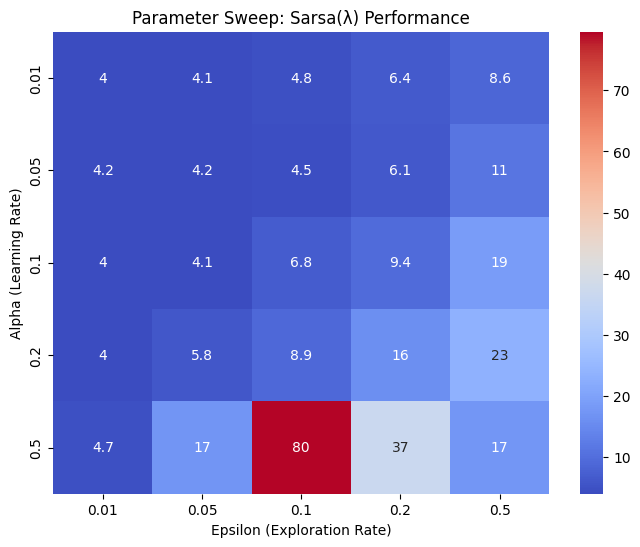

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
alphas = [0.01, 0.05, 0.1, 0.2, 0.5]
epsilons = [0.01, 0.05, 0.1, 0.2, 0.5]

results = {}

for alpha in alphas:
    for epsilon in epsilons:
      agent = SARSAAgent(actions=[0, 1])
      Q, policy, episode_rewards = agent.train(numIters=2500,epsilon=epsilon,discount=0.99,eta=alpha,epsilonDecay=False,etaDecay=False)
      avg_reward = np.mean(episode_rewards[-100:])  # Last 100 episodes
      results[(alpha, epsilon)] = avg_reward

# Convert to heatmap
alpha_vals, epsilon_vals, avg_rewards = zip(*[(a, e, r) for (a, e), r in results.items()])
plt.figure(figsize=(8, 6))
sns.heatmap(np.array(avg_rewards).reshape(len(alphas), len(epsilons)), annot=True,
            xticklabels=epsilons, yticklabels=alphas, cmap="coolwarm")
plt.xlabel("Epsilon (Exploration Rate)")
plt.ylabel("Alpha (Learning Rate)")
plt.title("Parameter Sweep: Sarsa(λ) Performance")
plt.show()

# Implementation of Mont-Carlos-Success

In [ ]:
import random
import math
from collections import defaultdict

LEARNING_RATE = 0.1
DISCOUNT_FACTOR = 0.99
EPSILON = 0.1
NUM_EPISODES = 50000

env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
#'TextFlappyBird-screen-v0' or 'TextFlappyBird-v0', only difference would be returned observation
#I choose env2, which would return  the distance of the player from the center of the closest upcoming pipe gap (TextFlappyBird-v0) along the two axes (x,y)
obs = env.reset()

class MonteCarloQLearningAgent:
    def __init__(self):
        self.epsilon = EPSILON
        self.Q = defaultdict(lambda: [0, 0])  # Q-values for actions 0 (Flap) and 1 (Do Nothing)
        self.returns = defaultdict(list)  # Stores returns for each state-action pair

    def policy(self, state):
        """Epsilon-greedy policy selection."""
        if random.uniform(0, 1) < self.epsilon:
            return env.action_space.sample()
        return np.argmax(self.Q[state])

    def update(self, episode_data):
        """Monte Carlo Q-Learning update."""
        G = 0
        visited_state_actions = set()
        for state, action, reward in reversed(episode_data):
            # print(f"Reward type: {type(reward)}, Value: {reward}")
            # print(f"G type: {type(G)}, Value: {G}")
            G = DISCOUNT_FACTOR * G + reward
            if (state, action) not in visited_state_actions:
                visited_state_actions.add((state, action))
                self.returns[(state, action)].append(G)
                self.Q[state][action] = np.mean(self.returns[(state, action)])
                self.Q[state][action] += LEARNING_RATE * (G - self.Q[state][action]) #or use learning rate to do the updates

    def train(self, num_episodes=NUM_EPISODES):
        """Train the agent over multiple episodes."""
        episode_rewards = []
        for episode in range(num_episodes):
            state, info = env.reset()
            done = False
            episode_data = []
            total_reward = 0

            while not done:
                action = self.policy(state)
                next_state, reward, done, _, info = env.step(action)
                episode_data.append((state, action, reward))
                total_reward += reward
                state = next_state

            episode_rewards.append(total_reward)
            self.update(episode_data)
            self.epsilon = max(self.epsilon - 0.001, 0.1)  # Decay epsilon

        return self.Q, self.get_optimal_policy(), episode_rewards

    def get_optimal_policy(self):
        """Extract the optimal policy from Q-values."""
        return {state: np.argmax(actions) for state, actions in self.Q.items()}


In [ ]:
# Initialize and train the agent
agent = MonteCarloQLearningAgent()
Q, policy, episode_rewards = agent.train()

In [ ]:
import os
import sys
import time
import gymnasium as gym
import text_flappy_bird_gym

# Initialize environment
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

# Function to choose action based on learned policy
def select_action(state):
    return policy.get(state, env.action_space.sample())  # Default to a random action if state is unseen

# Reset environment before running learned policy
state, info = env.reset()
done = False

# Game loop using the learned policy
while not done:
    action = select_action(state)  # Get action from policy
    print('state is', state)
    state, reward, done, _, info = env.step(action)

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2)  # Adjust speed for FPS control

env.close()

流式输出内容被截断，只能显示最后 5000 行内容。
[             |      ]
[             |      ]
[   |         |      ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=7,dy=4)
state is (7, 4)
Text Flappy Bird!
Score: 3028
----------------------
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |         |       ]
[  |                 ]
[  |                 ]
[  |                 ]
[  |                 ]
[  |         |       ]
[  |   @     |       ]
[            |       ]
[            |       ]
[            |       ]
[            |       ]
[  |         |       ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=6,dy=3)
state is (6, 3)
Text Flappy Bird!
Score: 3028
----------------------
[ |         |        ]
[ |         |        ]
[ |         |        ]
[ |         |        ]
[ |                  ]
[ |                  ]
[ |                  ]
[ |                  ]
[ |    @    |        ]
[ |         |        ]
[           |        ]
[           |     

KeyboardInterrupt: 

## Save best model using pickle

In [ ]:
# save training result Q and Policy
import pickle
import os
from collections import defaultdict

def default_value():
    return [0, 0]

data_Q = defaultdict(default_value)  # Use the regular function here
for k, v in Q.items():
    data_Q[k] = v

In [ ]:
# save training result Q and Policy
import pickle
import os
best_model_mont_carlo = {
        "Q": data_Q,
        "policy": policy,
        "episode_rewards": episode_rewards
    }
filename = "/content/drive/MyDrive/Reinforcement Learning/individual assignment/best_model_mont_carlo.pkl"
with open(filename, "wb") as f:
    pickle.dump(best_model_mont_carlo, f)

In [ ]:
## stock the best model Q
with open("monte_final.txt", "w") as f:
    f.write(str(agent.Q))
with open("results_final.txt", "w") as f:
    f.write(str(episode_rewards))

In [ ]:
agent

## get model with best results

In [ ]:
import pickle
def default_value():
    return [0, 0]

filename = "/content/drive/MyDrive/Reinforcement Learning/individual assignment/best_model_mont_carlo.pkl"
if __name__ == "__main__":
  with open(filename, "rb") as f:
      best_model_mont_carlo = pickle.load(f)

  # Extract Q, policy, and episode_rewards
#load my stocked best model from files
agent_best_mc= MonteCarloQLearningAgent()
agent_best_mc.Q = best_model_mont_carlo["Q"]
agent_best_mc.policy = best_model_mont_carlo["policy"]
agent_best_mc.episode_rewards = best_model_mont_carlo["episode_rewards"]


In [ ]:
import os
import sys
import time
import gymnasium as gym
import text_flappy_bird_gym

policy_best_mc= agent_best_mc.policy

# Initialize environment
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

# Function to choose action based on learned policy
def select_action(state):
    return policy_best_mc.get(state, env.action_space.sample())  # Default to a random action if state is unseen

# Reset environment before running learned policy
state, info = env.reset()
done = False

# Game loop using the learned policy
while not done:
    action = select_action(state)  # Get action from policy
    print('state is', state)
    state, reward, done, _, info = env.step(action)

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2)  # Adjust speed for FPS control

env.close()

state is (13, -2)
Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[      @           | ]
[                    ]
[                    ]
[                    ]
[                    ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=12,dy=-3)
state is (12, -3)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[      @          |  ]
[                 |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=11,dy=-4)
state is (11, -4)
Te

KeyboardInterrupt: 

## State-Value Function Plot

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_state_value_function(agent):
    """Plots the state-value function V(s) derived from Q-values."""

    # Extract unique states from Q-table
    states = list(agent.Q.keys())

    # Compute V(s) as max Q(s, a)
    V = {state: max(agent.Q[state]) for state in states}

    # Convert states into a 2D grid (if applicable)
    x_coords = [s[0] for s in states]  # Assuming state is tuple (x, y, ...)
    y_coords = [s[1] for s in states]
    values = [V[s] for s in states]

    # Create a scatter plot or heatmap
    plt.figure(figsize=(8, 6))
    plt.scatter(x_coords, y_coords, c=values, cmap='viridis', marker='s', s=100)
    plt.colorbar(label="State Value V(s)")
    plt.xlabel("State Dimension 0")
    plt.ylabel("State Dimension 1")
    plt.title("Monte Carlo State-Value Function")
    plt.show()


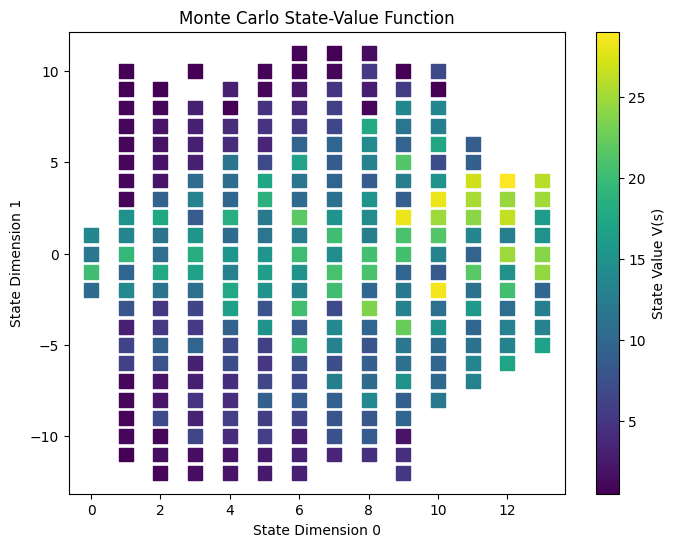

In [ ]:
plot_state_value_function(agent_best_mc)

## Performance Graph (Reward per Episode)

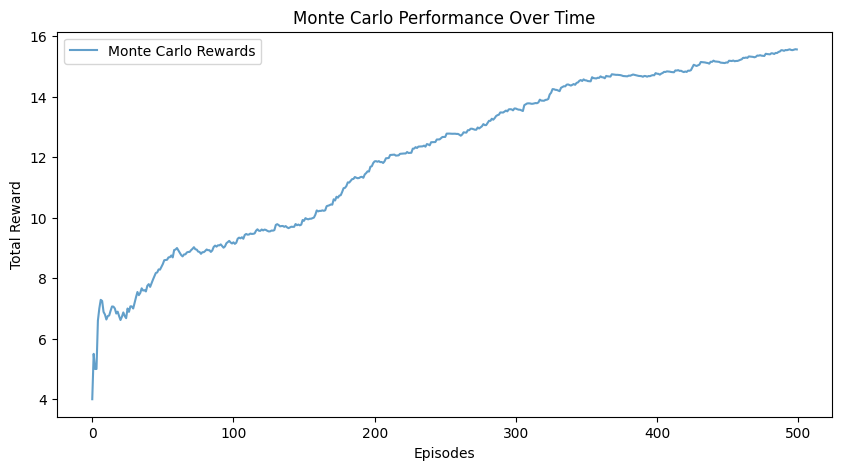

In [ ]:
# Assuming 'episode_rewards' stores total rewards per episode
plt.figure(figsize=(10, 5))
#plot the average of reward
plt.plot(np.arange(len(episode_rewards)), np.array(episode_rewards).cumsum()/ np.arange(1, len(episode_rewards) + 1), label="Monte Carlo Rewards", alpha=0.7)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Monte Carlo Performance Over Time")
plt.legend()
plt.show()


## parameter-sweep analysis

In [ ]:
DISCOUNT_FACTORS = [0.85, 0.9, 0.95, 0.99, 0.999]
EPSILON = [0.5,0.3,0.2,0.1]
results = {}

for epsilon in EPSILON:
  for dis_fac in DISCOUNT_FACTORS:
      agent= MonteCarloQLearningAgent()
      agent.epsilon = epsilon
      DISCOUNT_FACTOR = dis_fac
      Q,policy,episode_rewards  = agent.train(num_episodes=5000)
      avg_reward = np.mean(episode_rewards[-100:])  # Last 100 episodes
      results[(epsilon, dis_fac)] = avg_reward



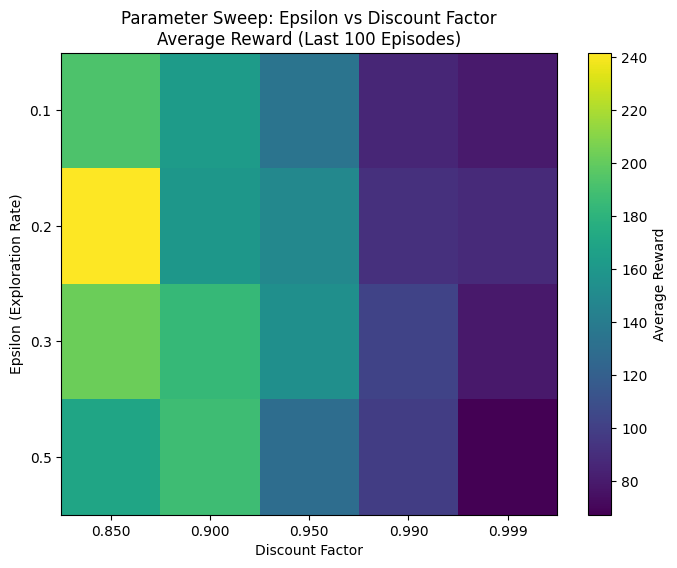

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `results` is populated with the (epsilon, discount_factor) as keys and avg_reward as values
DISCOUNT_FACTORS = [0.85, 0.9, 0.95, 0.99, 0.999]
EPSILON = [0.5, 0.3, 0.2, 0.1]

# Prepare data for the heatmap
heatmap_data = np.zeros((len(EPSILON), len(DISCOUNT_FACTORS)))

# Fill the heatmap data with average rewards
for i, epsilon in enumerate(EPSILON):
    for j, dis_fac in enumerate(DISCOUNT_FACTORS):
        heatmap_data[i, j] = results.get((epsilon, dis_fac), 0)

# Create the heatmap plot
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data, cmap='viridis', aspect='auto', origin='lower', interpolation='nearest')
plt.colorbar(label="Average Reward")

# Set the x and y axis labels
plt.xticks(np.arange(len(DISCOUNT_FACTORS)), [f"{d:.3f}" for d in DISCOUNT_FACTORS])
plt.yticks(np.arange(len(EPSILON)), [f"{e}" for e in EPSILON])
plt.xlabel("Discount Factor")
plt.ylabel("Epsilon (Exploration Rate)")
plt.title("Parameter Sweep: Epsilon vs Discount Factor\nAverage Reward (Last 100 Episodes)")
plt.show()


# Test agent in a specific configuration of the TFB environment

- in this section,I'll change the configuration of the environment to see if the performance of models would change accordingly

In [ ]:
# test best sarsa
# try model performance
import os
import sys
import time
import gymnasium as gym
import text_flappy_bird_gym

policy_best_sarsa= agent_best_sarsa.policy

# Initialize environment
env = gym.make('TextFlappyBird-v0', height=13, width=15, pipe_gap=7)  ##change the configuration, clear to find higher pip_gap
#leads to beeter performance

# Function to choose action based on learned policy
def select_action(state):
    return policy_best_sarsa.get(state, env.action_space.sample())  # Default to a random action if state is unseen

# Reset environment before running learned policy
state, info = env.reset()
done = False

# Game loop using the learned policy
while not done:
    action = select_action(state)  # Get action from policy
    print('state is', state)
    state, reward, done, _, info = env.step(action)

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2)  # Adjust speed for FPS control

env.close()

流式输出内容被截断，只能显示最后 5000 行内容。
state is (2, 0)
Text Flappy Bird!
Score: 540
-----------------
[     |       | ]
[     |       | ]
[     |         ]
[     |         ]
[     |         ]
[               ]
[               ]
[    @          ]
[               ]
[             | ]
[             | ]
[             | ]
[     |       | ]
^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=1,dy=-1)
state is (1, -1)
Text Flappy Bird!
Score: 540
-----------------
[    |       |  ]
[    |       |  ]
[    |          ]
[    |          ]
[    |          ]
[               ]
[    @          ]
[               ]
[               ]
[            |  ]
[            |  ]
[            |  ]
[    |       |  ]
^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=0,dy=-2)
state is (0, -2)
Text Flappy Bird!
Score: 541
-----------------
[   |       |   ]
[   |       |   ]
[   |           ]
[   |           ]
[   |           ]
[    @          ]
[               ]
[               ]
[               ]
[         

KeyboardInterrupt: 

In [ ]:
# test best mont-carlos